In [1]:
%autoreload 2

In [2]:
from collections import defaultdict, Counter
from itertools import combinations, chain
import json
from types import SimpleNamespace
import typing


import colorcet as cc
import krippendorff
from IPython.display import display, HTML, Markdown
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


In [3]:
class ExtendedSimpleNamespace(SimpleNamespace):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __contains__(self, key):
        return hasattr(self, key)

    def __getitem__(self, key):
        return getattr(self, key)

    def get(self, key, default=None):
        return getattr(self, key, default)

    def keys(self):
        return [k for k in vars(self).keys() if not k.startswith("_")]
        

In [4]:
TOP_30_UNMATCHED_FULL_GAME_IDS = [
    '(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)-unmatched',
    '(1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0)-unmatched',
    '(1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0)-unmatched',
    '(1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
 ]

In [9]:
PREVIOUS_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_02-01_data.json'
CURRENT_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_02-02_data.json'

GAME_KEYS = [
    'id', 'real', 'matched', 
    'confident', 'fun_play', 'fun_watch', 
    'capability', 'goldilocks', 'creativity',
    'human-likeness', 'explain', 'overall'
]

RENAMED_GAME_KEYS = {
    'id': 'game_id',
    'human-likeness': 'human_likeness'
}

NUMBER_SCORE_ATTRIBUTES = [
    'confident', 'fun_play', 
    'fun_watch',  'capability', 
    'goldilocks', 'creativity',
    'human_likeness',
]

NUMBER_SCORE_AXIS_NAMES = {
    'confident': 'How confident are you that you understand the game?',
    'fun_play': 'How fun would it be to play the game yourself?',
    'fun_watch': 'How fun would it be to watch someone else play the game?',
    'capability': 'How helpful would it be for learning to interact',
    'goldilocks': 'Too easy, appropriately difficult, or too hard for you?',
    'creativity': 'How creatively designed is the game?',
    'human_likeness': 'How human-like do you think this game is?',
}


def load_data(data_path: str) -> typing.Tuple[typing.List[ExtendedSimpleNamespace], typing.List[ExtendedSimpleNamespace]]:
    with open(data_path, 'r') as f:
        raw_data = json.load(f, object_hook=lambda d: ExtendedSimpleNamespace(**d))

    prolific_participants_data = []
    non_prolific_participants_data = []

    for participant_data in raw_data:
        if participant_data.data.recruitment_service == 'prolific':
            prolific_participants_data.append(participant_data)
        else:
            non_prolific_participants_data.append(participant_data)

    return prolific_participants_data, non_prolific_participants_data


def real_matched_to_str(series: pd.Series) -> str:
    if series.real:
        return 'real'

    if series.matched:
        return 'matched'

    return 'unmatched'


def full_game_id_to_str(series: pd.Series) -> str:
    return f"{series.game_id}-{series.game_type}"


def loaded_data_to_df(loaded_data: typing.List[ExtendedSimpleNamespace]):
    rows = []

    for participant in loaded_data:
        participant_id = participant.id

        for game_result in participant.data.single_game_results:
            rows.append({
                'participant_id': participant_id,
                **{RENAMED_GAME_KEYS.get(key, key): game_result[key] for key in GAME_KEYS}
            })
    
    df = pd.DataFrame(rows)
    df = df.assign(game_type=df.apply(real_matched_to_str, axis=1))
    df = df.assign(full_game_id=df.apply(full_game_id_to_str, axis=1))

    top_30_df = df[df.full_game_id.isin(TOP_30_UNMATCHED_FULL_GAME_IDS)].copy()
    top_30_df.game_type = 'unmatched_top_30'
    top_30_df = top_30_df.assign(full_game_id=top_30_df.apply(full_game_id_to_str, axis=1))

    df = pd.concat([df, top_30_df])
    df = df.assign(game_type=pd.Categorical(df.game_type, categories=['real', 'matched', 'unmatched', 'unmatched_top_30'], ordered=True))
    
    return df


def load_data_to_df(data_path: str, prolific_only: bool = True):
    prolific_participants_data, non_prolific_participants_data = load_data(data_path)
    if not prolific_only:
        prolific_participants_data.extend(non_prolific_participants_data)

    prolific_participants_data = list(filter(lambda p: p.data.get('quiz_passed', True), prolific_participants_data))

    return prolific_participants_data, loaded_data_to_df(prolific_participants_data)


current_participants_raw_data, current_participants_df = load_data_to_df(CURRENT_DATA_PATH)
previous_participants_raw_data, previous_participants_df = load_data_to_df(PREVIOUS_DATA_PATH)
print(f'Loaded current participant data with shape {current_participants_df.shape} from {CURRENT_DATA_PATH}')
print(f'Loaded previous participant data with shape {previous_participants_df.shape} from {PREVIOUS_DATA_PATH}')

current_participant_ids = set(current_participants_df.participant_id)
previous_participant_ids = set(previous_participants_df.participant_id)
new_participant_ids = current_participant_ids - previous_participant_ids
print(f"{len(current_participant_ids)} total participants | {len(new_participant_ids)} new participants:")
for participant_id in sorted(new_participant_ids):
    print(f"\t{participant_id}")

print(f'Dataframe shape: {current_participants_df.shape}')
current_participants_df.head()


Loaded current participant data with shape (1292, 15) from ./human_evals_data/real-complete_only-main-pilot_02-02_data.json
Loaded previous participant data with shape (1279, 15) from ./human_evals_data/real-complete_only-main-pilot_02-01_data.json
100 total participants | 1 new participants:
	37db5bea-1840-49a8-96af-840f5322fd21-p207
Dataframe shape: (1292, 15)


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,4,3,3,5,3,2,2,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,4,3,3,4,3,3,2,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,4,2,2,5,4,3,2,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,5,4,4,3,2,2,2,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,1,1,1,1,5,1,3,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


In [10]:
def add_linebreaks(string: str, n_lines: int = 2, min_break_length: int = 36):
    if len(string) <= min_break_length:
        return string

    prev_break_index = 0
    line_parts = []

    for break_index in range(1, n_lines):
        break_index = string.find(' ', int(break_index * len(string) / n_lines))
        if break_index == -1:
            break

        line_parts.append(string[prev_break_index:break_index])
        prev_break_index = break_index + 1

    line_parts.append(string[prev_break_index:])
    return '\n'.join(line_parts)


## Per-participant spread on each question

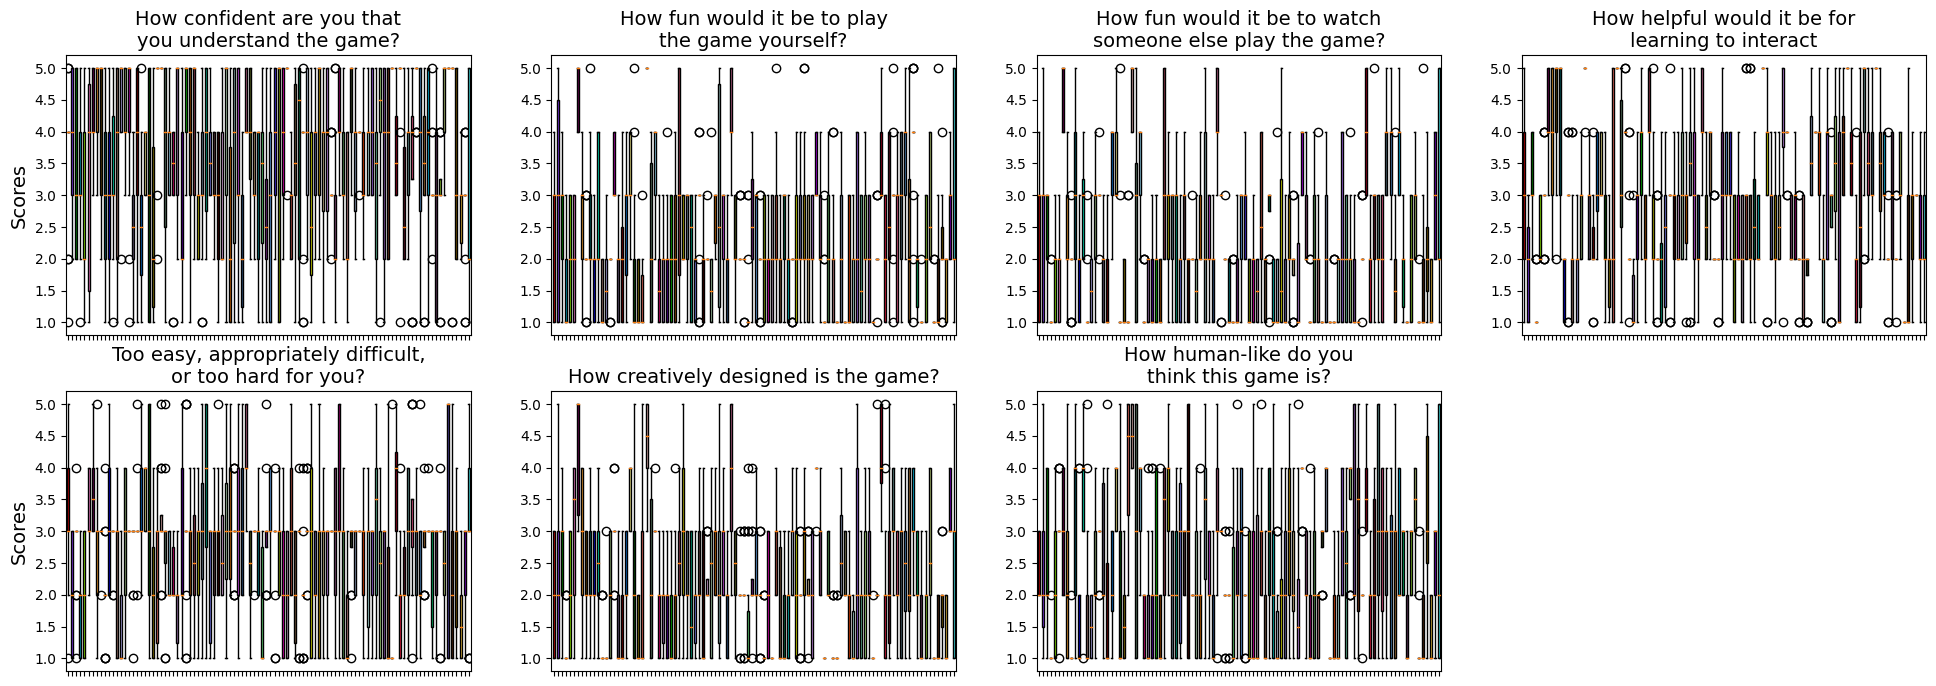

In [11]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 7
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
cmap = cc.cm.glasbey

grouped = current_participants_df.groupby('participant_id')
participant_ids = list(current_participants_df.participant_id.unique())
data_by_participant_id = {pid: {} for pid in participant_ids}

for i, (name, group) in enumerate(grouped):
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        data_by_participant_id[name][attribute] = group[attribute].values


for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    data = [data_by_participant_id[pid][attribute] for pid in participant_ids]
    positions = np.arange(len(data))
    bp = ax.boxplot(data, positions=positions, patch_artist=True)

    # Loop over each boxplot and set the color
    for b, box in enumerate(bp['boxes']):
        box.set_facecolor(cmap(b))

    ax.set_xticklabels([''] * len(participant_ids))
    if i % NCOLS == 0:
        ax.set_ylabel('Scores', fontdict=FONTDICT)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)

    if i >= START_XLABELS_INDEX:
        ax.set_xticks(np.arange(len(participant_ids)))
        ax.set_xticklabels(participant_ids, rotation=90)
        ax.set_xlabel('Participant ID', fontdict=FONTDICT)

# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()

## Per-game type bar plot on each questiion

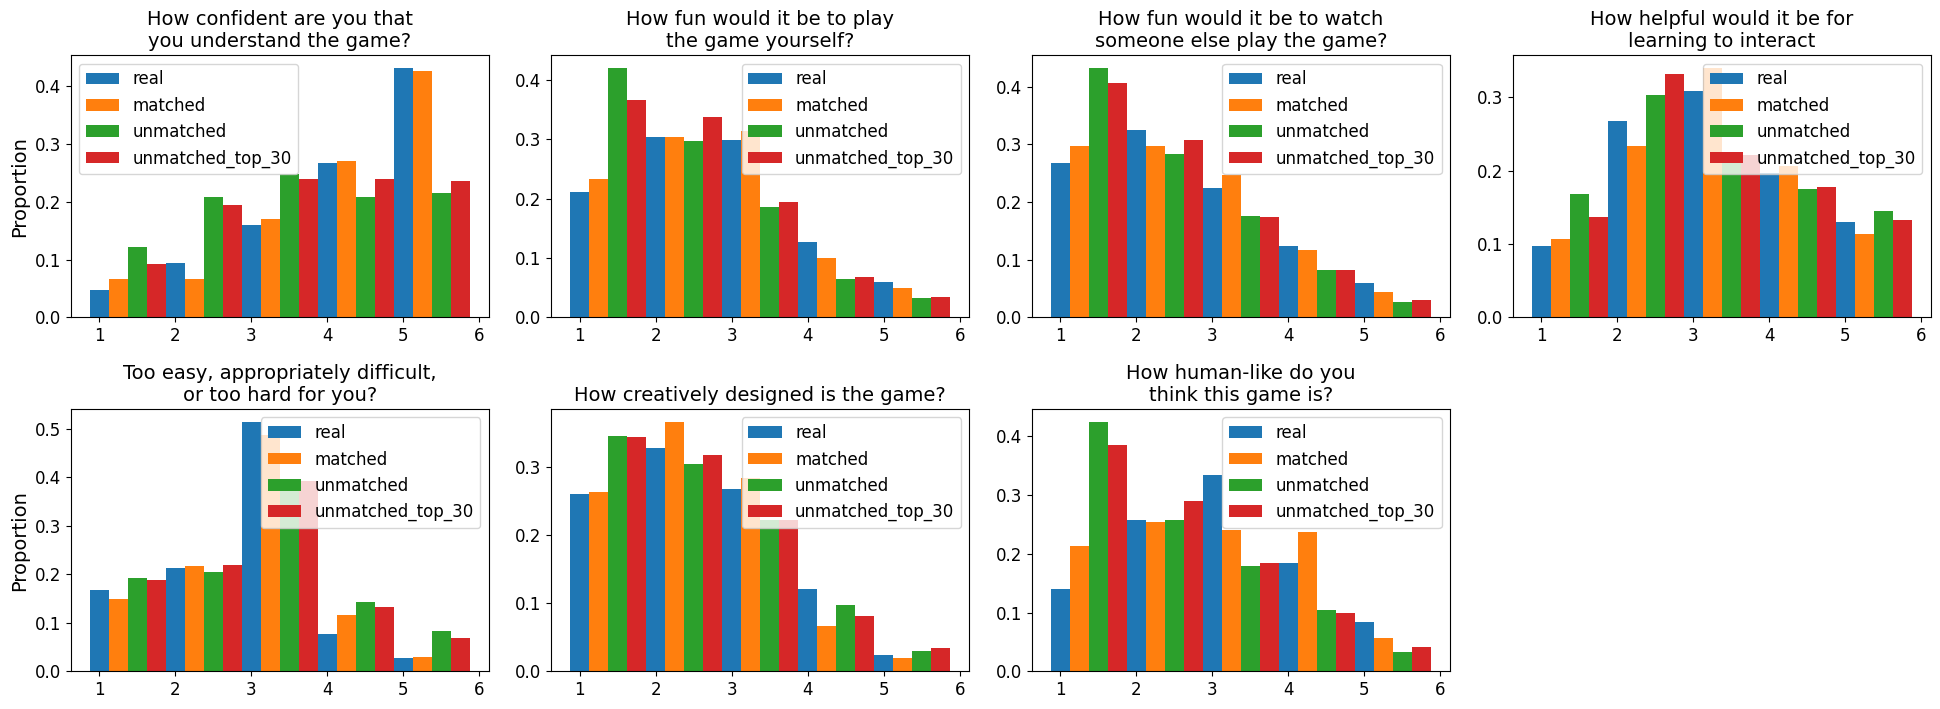

In [12]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = False


if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))

game_type_groupby = current_participants_df.groupby('game_type')
game_type_value_counts = current_participants_df.game_type.value_counts()

x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    multiplier = 0
    for game_type in current_participants_df.game_type.cat.categories:
        offset = width * multiplier
        normalized_value_counts = game_type_groupby.get_group(game_type)[attribute].value_counts().sort_index() / game_type_value_counts[game_type]
        ax.bar(x + offset, normalized_value_counts, width=width, label=game_type)
        multiplier += 1

    ax.set_xlabel('')

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()

if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


## Matched game difference comparison

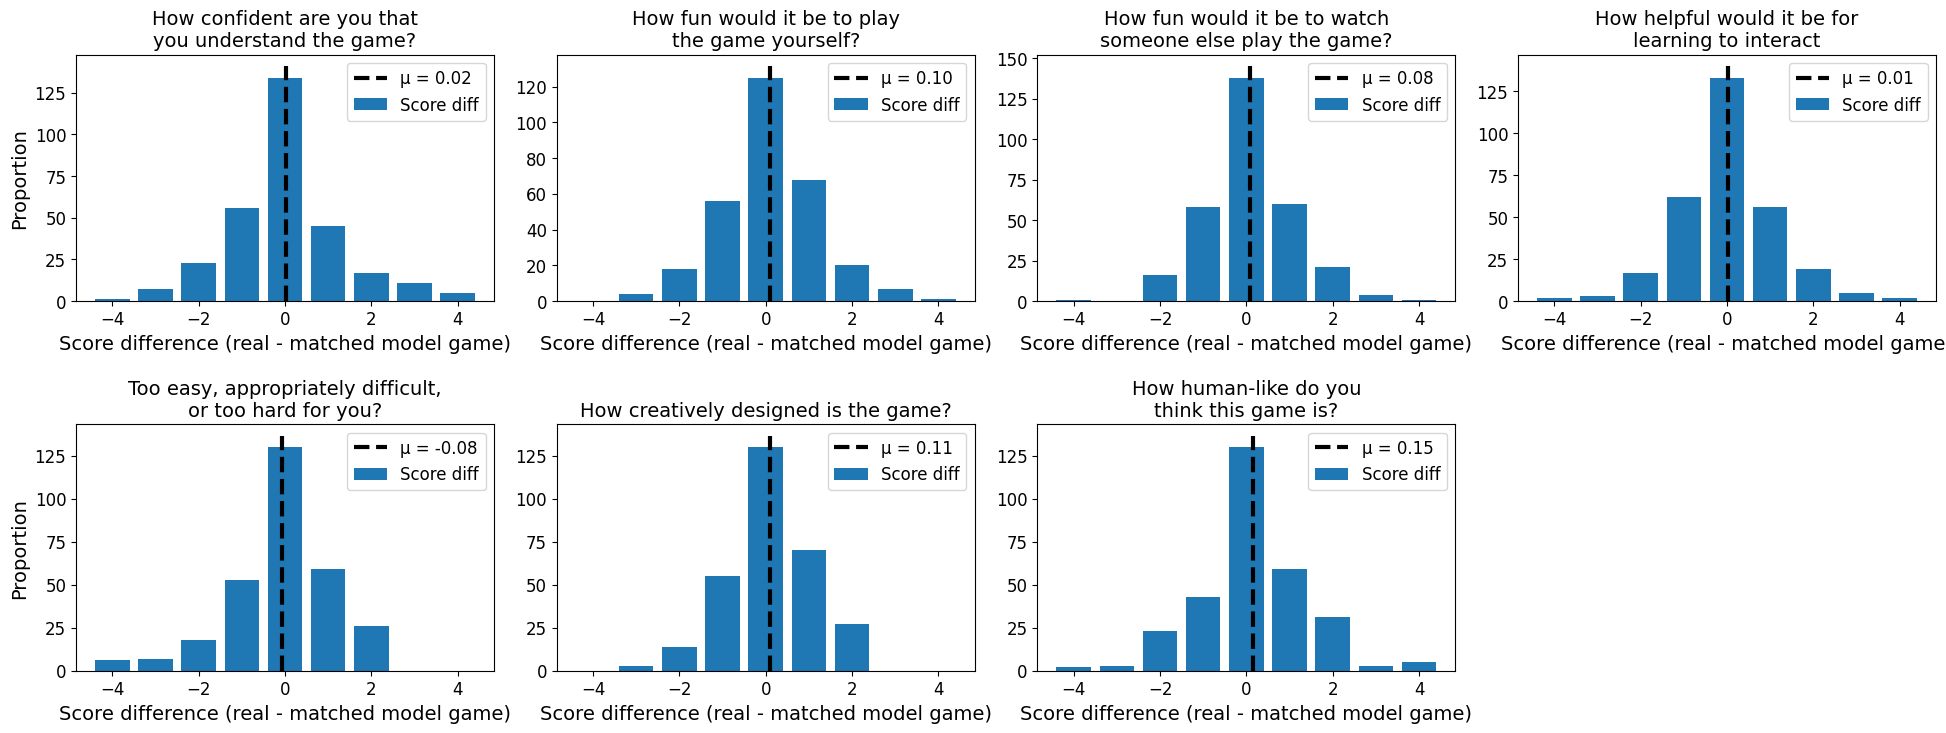

In [13]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    attribute_diff_counts = attribute_diffs.value_counts()
    ax.bar(x_values, [attribute_diff_counts.get(x, 0) for x in x_values], label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



## Run some matched-pairs t-tests

In [14]:
real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

confident:
	t-statistic = 0.21912596869609785
	p-value = 0.8267019285639725 

fun_play:
	t-statistic = 1.4694333064130782
	p-value = 0.14277019816909908 

fun_watch:
	t-statistic = 1.3148209591031503
	p-value = 0.1895810103987055 

capability:
	t-statistic = 0.20017977229676368
	p-value = 0.8414765256381358 

goldilocks:
	t-statistic = -1.0881976628447936
	p-value = 0.2773871540706674 

creativity:
	t-statistic = 1.8069461997523575
	p-value = 0.07177917977652712 

human_likeness:
	t-statistic = 2.010143767520546
	p-value = 0.045316874710284116 *



## And some unmatched t-tests between the unmatched games and other ones

In [15]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_df.game_type.cat.categories, 2):
        first_data = current_participants_df[current_participants_df.game_type == first][attribute]
        second_data = current_participants_df[current_participants_df.game_type == second][attribute]
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{tab}{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        print(f'{tab}{tab}t-statistic = {result.statistic:.3f}')
        print(f'{tab}{tab}tp-value    = {result.pvalue:.3e} {stars}')

    print()

    

confident:
    real (μ = 3.94) vs matched (μ = 3.92)
        t-statistic = 0.203
        tp-value    = 8.392e-01 
    real (μ = 3.94) vs unmatched (μ = 3.19)
        t-statistic = 7.871
        tp-value    = 1.343e-14 ***
    real (μ = 3.94) vs unmatched_top_30 (μ = 3.33)
        t-statistic = 6.053
        tp-value    = 2.536e-09 ***
    matched (μ = 3.92) vs unmatched (μ = 3.19)
        t-statistic = 7.599
        tp-value    = 9.616e-14 ***
    matched (μ = 3.92) vs unmatched_top_30 (μ = 3.33)
        t-statistic = 5.792
        tp-value    = 1.133e-08 ***
    unmatched (μ = 3.19) vs unmatched_top_30 (μ = 3.33)
        t-statistic = -1.459
        tp-value    = 1.450e-01 

fun_play:
    real (μ = 2.52) vs matched (μ = 2.43)
        t-statistic = 1.003
        tp-value    = 3.163e-01 
    real (μ = 2.52) vs unmatched (μ = 1.99)
        t-statistic = 6.278
        tp-value    = 6.039e-10 ***
    real (μ = 2.52) vs unmatched_top_30 (μ = 2.07)
        t-statistic = 5.003
        tp-valu

## Trying to compute some inter-annotator agreement data

In [16]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    pivot_table = pd.pivot_table(current_participants_df, values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 = {alpha:.3f}')
    pivot_table_real_matched_only = pd.pivot_table(current_participants_df[current_participants_df.game_type != 'unmatched'], values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table_real_matched_only.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 (real and matched only) = {alpha:.3f}')

    print()




confident:
    α = 0.228
    α (real and matched only) = 0.233

fun_play:
    α = 0.123
    α (real and matched only) = 0.117

fun_watch:
    α = 0.088
    α (real and matched only) = 0.077

capability:
    α = 0.016
    α (real and matched only) = 0.023

goldilocks:
    α = 0.202
    α (real and matched only) = 0.211

creativity:
    α = 0.115
    α (real and matched only) = 0.129

human_likeness:
    α = 0.150
    α (real and matched only) = 0.151



# Repeating some analyses with normalized scores
Normalizing within each (participant X question)

In [17]:
current_participants_normalized_df = current_participants_df.copy()

participant_ids = current_participants_df.participant_id.unique()

for participant_id in participant_ids:
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        attribute_mean = current_participants_normalized_df[current_participants_normalized_df.participant_id == participant_id][attribute].mean()
        attribute_std = current_participants_normalized_df[current_participants_normalized_df.participant_id == participant_id][attribute].std()

        if attribute_std == 0:
            current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] = 0
        else:
            current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] = (current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] - attribute_mean) / attribute_std


current_participants_normalized_df.head()
    

,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,0.322413,0.549011,0.549011,1.286352,-0.227866,0.000000,-0.889499,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,0.322413,0.549011,0.549011,0.526235,-0.227866,1.224745,-0.889499,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,0.322413,-0.343132,-0.343132,1.286352,0.759555,1.224745,-0.889499,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,1.160687,1.441153,1.441153,-0.233882,-1.215287,0.000000,-0.889499,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,-2.192408,-1.235274,-1.235274,-1.754116,1.746975,-1.224745,1.037749,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


## Histogram of the values per question

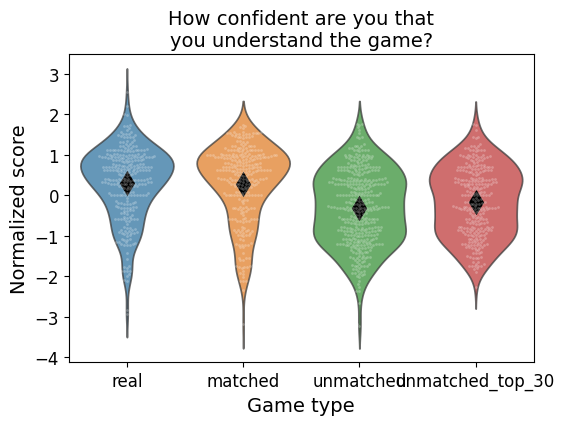

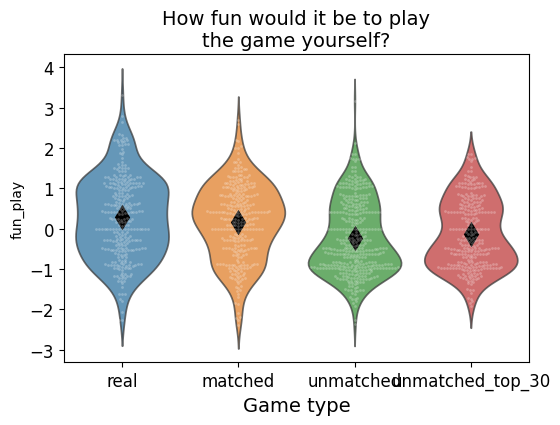

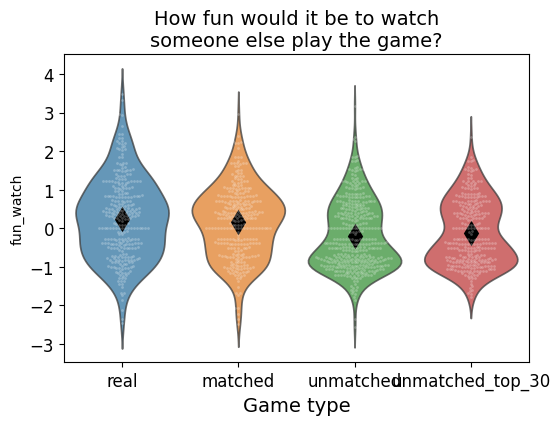

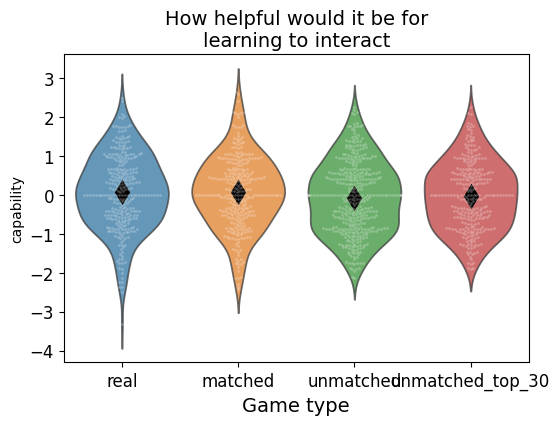

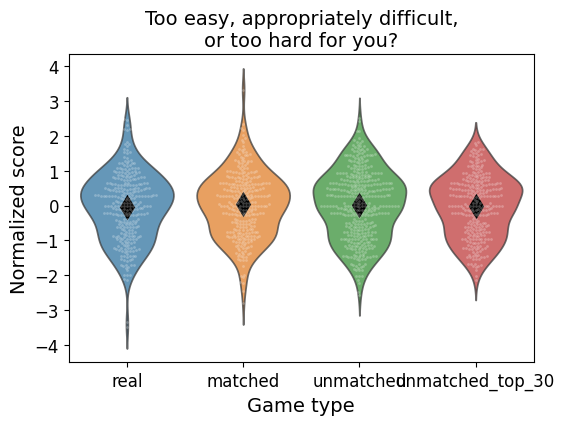

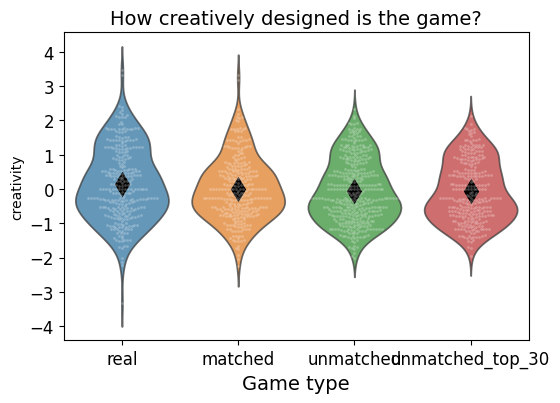

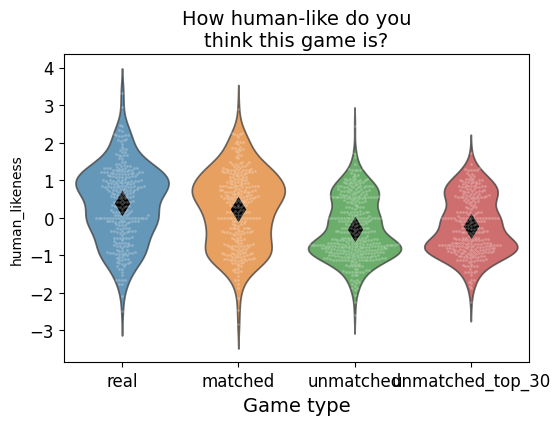

In [19]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = True
N_BINS = 20

if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))


x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    histotgram_data = [current_participants_normalized_df[current_participants_normalized_df.game_type == game_type][attribute] for game_type in current_participants_df.game_type.cat.categories]
    # ax.hist(histotgram_data, bins=N_BINS, label=current_participants_df.game_type.cat.categories, alpha=0.75, density=True)
    
    # bodies = ax.violinplot(histotgram_data, showmeans=True, showextrema=True, vert=True, widths=0.7)
    # legend_entries = []
    # for i, pc in enumerate(bodies['bodies']):
    #     pc.set_facecolor(cm.tab10(i))
    #     legend_entries.append(mpatches.Patch(facecolor=pc.get_facecolor(), label=current_participants_df.game_type.cat.categories[i]))

    sns.violinplot(data=current_participants_normalized_df, x='game_type', y=attribute, ax=ax, hue='game_type', palette='tab10', inner=None, alpha=0.75)
    sns.swarmplot(data=current_participants_normalized_df, x='game_type', y=attribute, ax=ax, color='white', dodge=False, size=2, alpha=0.25)
    # draw means and confidence intervals around them
    # means = current_participants_normalized_df.groupby('game_type')[attribute].mean()
    # stds = current_participants_normalized_df.groupby('game_type')[attribute].std()
    # for i, game_type in enumerate(current_participants_df.game_type.cat.categories):
    #     ax.errorbar(i, means[game_type], yerr=1.96 * stds[game_type] / np.sqrt(len(histotgram_data[i])), fmt='-', color='black', 
    #                 elinewidth=2, capthick=2, capsize=15, barsabove=True)

    sns.pointplot(data=current_participants_normalized_df, x='game_type', y=attribute, ax=ax, errorbar=('ci', 95), linestyle='none', color='black', markers='d',
                  markersize=10)
    
    ax.set_xlabel('Game type', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Normalized score', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    # ax.legend(handles=legend_entries, loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()


if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


In [ ]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_normalized_df.game_type.cat.categories, 2):
        first_data = current_participants_normalized_df[current_participants_normalized_df.game_type == first][attribute]
        second_data = current_participants_normalized_df[current_participants_normalized_df.game_type == second][attribute]
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        p = result.pvalue
        p_value_str = f'p-value < 1e-7 {stars}' if p < 1e-7 else (f'p-value < 1e-5 {stars}' if p < 1e-5 else f'p-value = {p:.4f} {stars}')
        print(f'{tab}t-statistic = {result.statistic:.3f}, {p_value_str}')
        print()
        # print(f'{tab}p-value    = {result.pvalue:.3e} {stars}')

    print()

    

In [ ]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
N_BINS = 20

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_normalized_df[current_participants_normalized_df.game_type == 'real'].merge(
    current_participants_normalized_df[current_participants_normalized_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    # attribute_diff_counts = attribute_diffs.value_counts()
    ax.hist(attribute_diffs, bins=N_BINS, density=True, label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



In [ ]:
real_matched_df = current_participants_normalized_df[current_participants_normalized_df.game_type == 'real'].merge(
    current_participants_normalized_df[current_participants_normalized_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

# Trying to run some mixed effects models

In [ ]:
current_participants_normalized_df = current_participants_normalized_df.assign(
    game_type_real=pd.Series(current_participants_normalized_df.game_type == 'real', dtype=int),
    game_type_matched=pd.Series(current_participants_normalized_df.game_type == 'matched', dtype=int),
    game_type_unmatched=pd.Series(current_participants_normalized_df.game_type == 'unmatched', dtype=int),
    game_type=current_participants_normalized_df.game_type.cat.reorder_categories(['unmatched', 'matched', 'real']),
)

current_participants_normalized_df.head()

In [ ]:
# vc = {'participant_id': '0 + C(participant_id)'}
# md = smf.mixedlm('confident ~ game_type', current_participants_normalized_df, groups='game_type', vc_formula=vc)
# mdf = md.fit()

vc = {'full_game_id': '0 + C(full_game_id)'}
for attribute in NUMBER_SCORE_ATTRIBUTES:
    display(Markdown(f'### {attribute}:'))
    md = smf.mixedlm(f'{attribute} ~ game_type + 1', current_participants_normalized_df, groups='participant_id', vc_formula=vc)
    mdf = md.fit()
    display(mdf.summary())
    display(Markdown('-----------'))




In [ ]:
# debrief_key = 'comments'
debrief_key = 'strategy'
# debrief_key = 'aids'
# debrief_key = 'techDifficulties'

min_length = 10

for participant_data in current_participants_raw_data:
    debrief_responses = participant_data.data.debrief_responses
    if debrief_key in debrief_responses and len(debrief_responses[debrief_key]) > min_length:
        print(f'{debrief_responses[debrief_key]}')



In [ ]:
current_participants_normalized_df

In [ ]:
TOP_30_UNMATCHED_FULL_GAME_IDS = [
    '(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)-unmatched',
    '(1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0)-unmatched',
    '(1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0)-unmatched',
    '(1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
 ]


current_participants_normalized_df[current_participants_normalized_df.full_game_id.isin(TOP_30_UNMATCHED_FULL_GAME_IDS)]